# Предсказание рейтинга ресторана на сайте TripAdvisor  
Задача: Обучить модель, которая будет предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.

# Импорт библиотек

In [94]:
from sklearn import metrics  # инструменты для оценки точности модели
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
# специальный инструмент для разбивки
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import numpy as np  # линейная алгебра
import pandas as pd  # работа с файлами

import re  # регулярные выражения
from datetime import datetime  # работа с датами

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# вывод красивых и понятных графиков

# Для работы в оффлайн режиме,чтобы выводились графики iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [95]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Импорт данных

In [96]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Внешние данные
# https://worldpopulationreview.com/world-cities
df_population = pd.read_csv('population_cities_2020.csv')

In [97]:
df_train.head(10)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765
8,id_2690,Vienna,NaN,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029
9,id_4209,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681


In [98]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [99]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [100]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [101]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [102]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [104]:
# Изменим названия столбцов для удобства
data.rename(columns={'Cuisine Style': 'Cuisine_Style', 'Price Range': 'Price_Range',
                     'Number of Reviews': 'Number_of_Reviews'}, inplace=True)

In [105]:
data.head(5)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


# Очистка и подготовка данных

Подробнее по признакам:
* Restaurant_id: id ресторана
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

## 0. Функции

In [106]:
# обработка Reviews
def proc_Reviews(line):
    line = line.replace('[', '')
    line = line.replace(']', '')
    line = line.replace("'", '')
    return line

# обработка Cuisine_Style


def proc_Cuisine_Style(line):
    line = line.replace('[', '')
    line = line.replace(']', '')
    line = line.replace("'", '')
    line = line.replace(" ", '')
    return line

# Диапазон цен в числах,целочисленное кодирование
# 0 - нет сведений, 1 - низкий, 2 - средний, 3 - высокий


def filter_price_range(line):
    line = line.strip()
    if line == '$':
        return 1
    elif line == '$$ - $$$':
        return 2
    elif line == '$$$$':
        return 3
    else:
        return 0

# Количество вхождений в комментарии ключевых хороших слов


def filter_good_comment(line):
    key_words = ['good', 'best', 'nice', 'better',
                 'amazing', 'excellent', 'great', 'wonderful']
    counter = 0
    for word in key_words:
        if word in line.lower():
            counter += 1
    return counter

# Разница в днях между датами отзывов


def get_date_difference(line):
    if len(line) != 2:
        return 0
    date1 = datetime.strptime(line[0], '%m/%d/%Y')
    date2 = datetime.strptime(line[1], '%m/%d/%Y')
    return (np.abs(date1 - date2)).days

# Показать график по value_counts


def show(col, t):
    data[col].value_counts(ascending=True).iplot(kind='barh', title=t)

# Удалить dummy признаки


def del_dummy(df):
    for col in df.columns:
        if 'dum_' in col:
            df = df.drop(col, axis=1)
    return df

## 1. Обработка NAN 


In [107]:
# Делаем отдельную колонку с информацией о NAN для Number_of_Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number_of_Reviews']).astype('uint8')

# Заменяем в Number_of_Reviews пропуски на 0. При замене пропусков на среднее или среднее по городам - МАЕ хуже.
data['Number_of_Reviews'].fillna(0, axis=0, inplace=True)
# среднее
#data['Number_of_Reviews'].fillna(round(data['Number_of_Reviews']),inplace = True)
# среднее по городам
#means = round(df_all.groupby('City')['Number_of_Reviews'].mean())
#data.Number_of_Reviews.fillna(df_all.City.map(means),inplace = True)

In [108]:
# Заменяем в Reviews пропуски на "[[], []]". Отдельно колонку не делаем,т.к. всего 2 NAN значения
data['Reviews'].fillna('[[], []]', inplace=True)

In [109]:
# Делаем отдельную колонку с информацией о NAN для Cuisine_Style
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine_Style']).astype('uint8')
# Заменяем в Cuisine_Style пропуски на [Other].Скобки для соблюдения формата list
data['Cuisine_Style'].fillna('[Other]', inplace=True)

In [110]:
# Делаем отдельную колонку с информацией о NAN для Price_Range
data['Price_Range_isNAN'] = pd.isna(data['Price_Range']).astype('uint8')
# Заменяем в Price_Range пропуски на '-'
data['Price_Range'].fillna('-', inplace=True)

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Restaurant_id            50000 non-null  object 
 1   City                     50000 non-null  object 
 2   Cuisine_Style            50000 non-null  object 
 3   Ranking                  50000 non-null  float64
 4   Price_Range              50000 non-null  object 
 5   Number_of_Reviews        50000 non-null  float64
 6   Reviews                  50000 non-null  object 
 7   URL_TA                   50000 non-null  object 
 8   ID_TA                    50000 non-null  object 
 9   sample                   50000 non-null  int64  
 10  Rating                   50000 non-null  float64
 11  Number_of_Reviews_isNAN  50000 non-null  uint8  
 12  Cuisine_Style_isNAN      50000 non-null  uint8  
 13  Price_Range_isNAN        50000 non-null  uint8  
dtypes: float64(3), int64(1

## 2. Обработка признаков

### Restaurant_id (id ресторана)
Практического смысла не несёт, можно удалить.

In [112]:
data.drop(['Restaurant_id'], axis=1, inplace=True)

### City (Город)

In [113]:
print('Количество городов: ', data['City'].nunique())

Количество городов:  31


In [114]:
show('City', 'Количество ресторанов в городах')

Добавим признак "Количество ресторанов в городе"

In [115]:
res_count = data['City'].value_counts()
data['Restaurants_Count'] = data['City'].map(res_count)

### Cuisine Style (Кухня)

Уберём лишние символы и добавим новый признак "Количество кухонь в ресторане"

In [116]:
data['Cuisine_Style'] = data['Cuisine_Style'].apply(proc_Cuisine_Style)
data['Quan_Cuisine_Style'] = data['Cuisine_Style'].apply(lambda x: len(x))

### Ranking (Ранг ресторана относительно других ресторанов в этом городе)

Нормализуем признак

In [117]:
# std нормализация
#means = data.groupby('City')['Ranking'].mean()
#std = data.groupby('City')['Ranking'].std()
#data['Ranking_std'] = (data.Ranking - data.City.map(means))/(data.City.map(std))

# minmax нормализация
min_rc = data.groupby('City')['Ranking'].min()
max_rc = data.groupby('City')['Ranking'].max()
data['Ranking_min_max'] = (data['Ranking'] - data['City'].map(min_rc)) / \
    (data['City'].map(max_rc) - data['City'].map(min_rc))

# minmax даёт результат МАЕ лучше,чем std.

Вычислим относительный ранг ресторана среди всех ресторанов города

In [118]:
data['Rel_Rank'] = data['Ranking'] / data['Restaurants_Count']

### Price Range (Цены в ресторане в 3 категориях)

In [119]:
data['Price_Range'].value_counts()

$$ - $$$    23041
-           17361
$            7816
$$$$         1782
Name: Price_Range, dtype: int64

 Цены в ресторане можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3. Для отсутствующих цен подставим 0,т.к. он даёт лучший показатель МАЕ,чем,например, мода. (2)


In [120]:
data['Price_Range'] = data['Price_Range'].apply(
    lambda x: x.strip())  # уберём отступы
data['Price_Range_level'] = data['Price_Range'].apply(filter_price_range)

### Number of Reviews (Количество отзывов)

In [121]:
show('City', 'Количество ресторанов в городах')

Добавим признак "Количество отзывов по городам"

In [122]:
quan_nor_city = data.groupby('City')['Number_of_Reviews'].sum()
data['Quan_NoR_City'] = data.City.map(quan_nor_city)

In [123]:
quan_nor_city.sort_values(ascending=True).iplot(
    kind='barh', title='Количество отзывов о ресторанах по городам')

В Лондоне больше всего ресторанов,соответственно,и отзывов.Логично. Что интереснов,в Риме меньше ресторанов,чем в Париже,при этом отзывов больше.Там живут более общительные люди?=)

### Reviews (2 последних отзыва и даты этих отзывов)

Уберём лишние символы в строках

In [124]:
data['Reviews'] = data['Reviews'].apply(proc_Reviews)

Пробежавшишь глазами по датасету,выделил следующие хорошие слова:
'good','best','nice','better','amazing','excellent','great','wonderful'.    
Добавим их в проверку на хорошие комментарии.

Разницу в днях решил считать только в строка,где есть 2 даты. Меньше 2-х разницу считать нет смысла,а строк с датами больше 2 всего четыре.Их обработка занимает дополнительное время у алгоритма + влияние на МАЕ незначительное.

In [125]:
data['Date_of_Reviews'] = data['Reviews'].str.findall(
    '\d+/\d+/\d+')  # Даты из отзывов

In [126]:
data['Date_of_Reviews'].apply(lambda x: len(
    x)).value_counts()  # Количество дат в отзывах

2    36202
0     8114
1     5680
3        4
Name: Date_of_Reviews, dtype: int64

Создадим 2 новых признака: "Количество хороших комментариев в отзывах" и "Разница в днях между датами отзывов". 

In [127]:
data['Good_Comments'] = data.Reviews.apply(filter_good_comment)
data['Date_Difference'] = data['Date_of_Reviews'].apply(get_date_difference)

### URL_TA (страница ресторана на 'www.tripadvisor.com')  
В url зашифрован код ресторана,попробуем использовать его для улучшения работы модели

In [128]:
data['URL_TA_code'] = data['URL_TA'].str.split(
    '-').apply(lambda x: x[1][1:]).astype('float64')

### ID_TA (ID ресторана в TripAdvisor)
Предположим, что индентификатор присваивается последовательно и по нему можно судить о возрасте ресторана. Уберём 'd' и попробуем использовать признак в модели

In [129]:
data['ID_TA'] = data['ID_TA'].apply(lambda x: x[1:]).astype('float64')

### Внешние данные

Получим дополнительные данные по городам: численность населения и страна

In [130]:
data = data.merge(df_population[[
                  'Name', 'Population', 'Country']], how='left', left_on='City', right_on='Name')
data.drop(['Name'], axis=1, inplace=True)

### Дополнительные признаки

In [131]:
# отношение среднего ранга по городу к численности населения города
mean_rc = data.groupby('City')['Ranking'].mean()
data['Ranking_City_mean'] = data.City.map(mean_rc) / data.Population

# Количество ресторанов в городе
res_count = data['City'].value_counts()
data['Restaurants_Count'] = data['City'].map(res_count)
# Относительный ранг ресторана среди всех ресторанов города
data['Rel_Rank'] = data['Ranking'] / data['Restaurants_Count']
# Отношение количества отзывов на население города
data['NoR_P'] = data['Number_of_Reviews'] / data['Population']
# Относительный ранг ресторана с учетом количества отзывов в городе по населению
data['RR_NoR_P'] = data['Rel_Rank'] * data['NoR_P']

# ранг ресторана относительно количества отзывов по городу
data['RR_QNC'] = data['Ranking'] / data['Quan_NoR_City']

Добавляем dummy-переменные

In [132]:
pref = 'dum_'

# хорошие слова в комментариях
key_words = ['good', 'best', 'nice', 'better',
             'amazing', 'excellent', 'great', 'wonderful']
for word in key_words:
    data[pref + word] = 0
    data[pref +
         word] = data['Reviews'].apply(lambda x: 1 if word in x.lower() else 0)

# типы кухонь
set_cuisine = set(pd.DataFrame(
    data['Cuisine_Style'].str.split(',').tolist()).stack())
for cuis in set_cuisine:
    data[pref + cuis] = 0
    data[pref +
         cuis] = data['Cuisine_Style'].apply(lambda x: 1 if cuis in x else 0)

# города
data = pd.get_dummies(data, columns=['City'], prefix='dum_city', dummy_na=True)
# страны
data = pd.get_dummies(
    data, columns=['Country'], prefix='dum_country', dummy_na=True)

# EDA 

### Посмотрим распределение признака

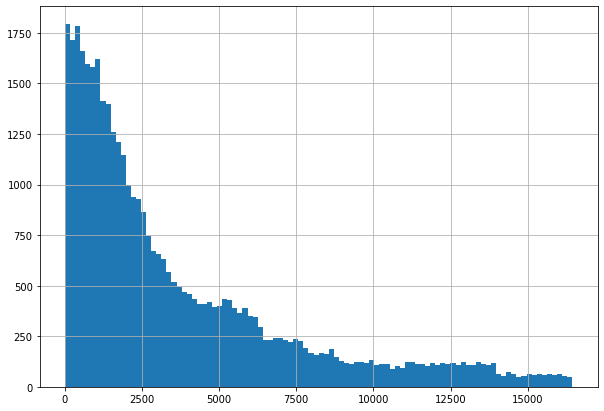

In [133]:
plt.rcParams['figure.figsize'] = (10, 7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе

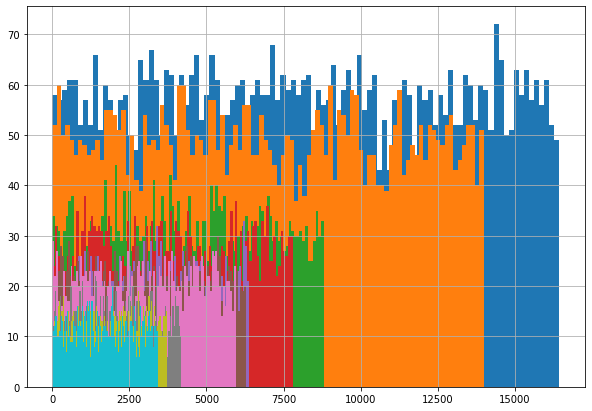

In [134]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Посмотрим распределение целевой переменной

In [135]:
df_train['Rating'].value_counts(ascending=True).iplot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

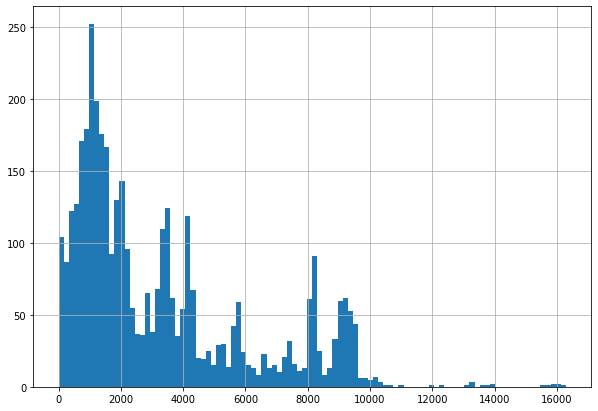

In [136]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

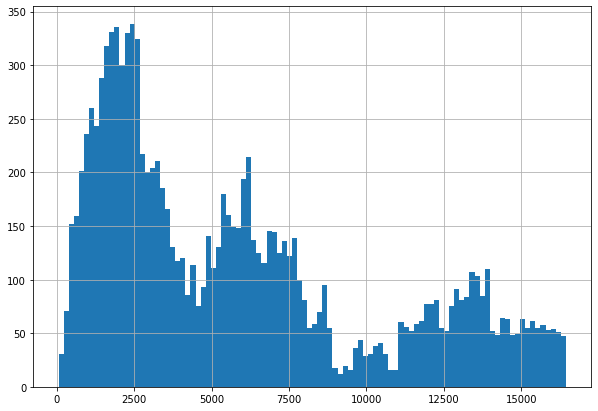

In [137]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Корреляция признаков
На этом графике можно заметить, как признаки связаны между собой и с целевой переменной.  
Посмотрим корреляции без dummy

In [138]:
data_temp = del_dummy(data)

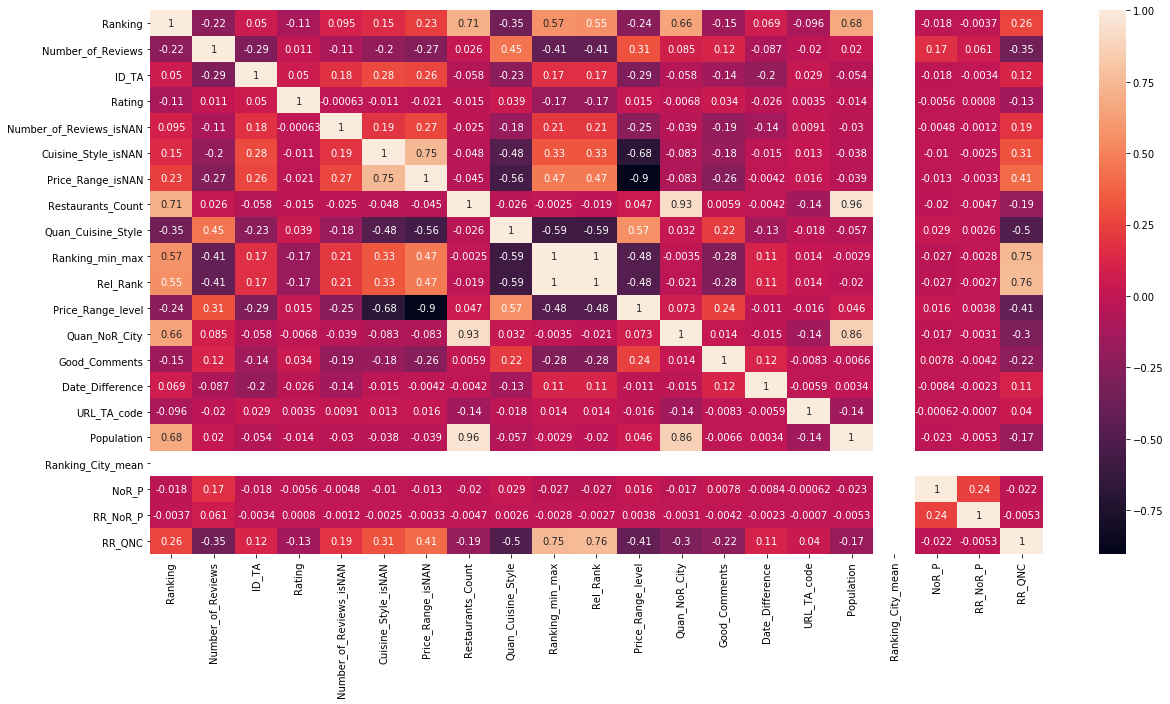

In [139]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.heatmap(round(data_temp.drop(['sample'], axis=1), 2).corr(), annot=True)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [140]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')

# Внешние данные
df_population = pd.read_csv('population_cities_2020.csv')

df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [141]:
# обработка Reviews
def proc_Reviews(line):
    line = line.replace('[', '')
    line = line.replace(']', '')
    line = line.replace("'", '')
    return line

# обработка Cuisine_Style


def proc_Cuisine_Style(line):
    line = line.replace('[', '')
    line = line.replace(']', '')
    line = line.replace("'", '')
    line = line.replace(" ", '')
    return line

# Диапазон цен в числах,целочисленное кодирование
# 0 - нет сведений, 1 - низкий, 2 - средний, 3 - высокий


def filter_price_range(line):
    line = line.strip()
    if line == '$':
        return 1
    elif line == '$$ - $$$':
        return 2
    elif line == '$$$$':
        return 3
    else:
        return 0

# Количество вхождений в комментарии ключевых хороших слов


def filter_good_comment(line):
    key_words = ['good', 'best', 'nice', 'better',
                 'amazing', 'excellent', 'great', 'wonderful']
    counter = 0
    for word in key_words:
        if word in line.lower():
            counter += 1
    return counter

# Разница в днях между датами отзывов


def get_date_difference(line):
    if len(line) != 2:
        return 0
    date1 = datetime.strptime(line[0], '%m/%d/%Y')
    date2 = datetime.strptime(line[1], '%m/%d/%Y')
    return (np.abs(date1 - date2)).days

In [142]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    df_output.rename(columns={'Cuisine Style': 'Cuisine_Style', 'Price Range': 'Price_Range',
                              'Number of Reviews': 'Number_of_Reviews'}, inplace=True)

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id'], axis=1, inplace=True)

    # ################### 2. NAN ##############################################################
    df_output['Number_of_Reviews_isNAN'] = pd.isna(
        df_output['Number_of_Reviews']).astype('uint8')
    df_output['Number_of_Reviews'].fillna(0, inplace=True)
    df_output['Reviews'].fillna('[[], []]', inplace=True)
    df_output['Cuisine_Style_isNAN'] = pd.isna(
        df_output['Cuisine_Style']).astype('uint8')
    df_output['Cuisine_Style'].fillna('[Other]', inplace=True)
    df_output['Price_Range_isNAN'] = pd.isna(
        df_output['Price_Range']).astype('uint8')
    df_output['Price_Range'].fillna('-', inplace=True)

    # ################### 3. Feature Engineering ####################################################
    df_output['Restaurants_Count'] = df_output['City'].map(
        df_output['City'].value_counts())
    df_output['Cuisine_Style'] = df_output['Cuisine_Style'].apply(
        proc_Cuisine_Style)
    df_output['Quan_Cuisine_Style'] = df_output['Cuisine_Style'].apply(
        lambda x: len(x))
    min_rc = df_output.groupby('City')['Ranking'].min()
    max_rc = df_output.groupby('City')['Ranking'].max()
    df_output['Ranking_min_max'] = (df_output['Ranking'] - df_output['City'].map(
        min_rc))/(df_output['City'].map(max_rc) - df_output['City'].map(min_rc))
    df_output['Rel_Rank'] = df_output['Ranking'] / \
        df_output['Restaurants_Count']
    df_output['Price_Range'] = df_output['Price_Range'].apply(
        lambda x: x.strip())
    df_output['Price_Range_level'] = df_output['Price_Range'].apply(
        filter_price_range)
    df_output['Quan_NoR_City'] = df_output['City'].map(
        df_output.groupby('City')['Number_of_Reviews'].sum())
    df_output['Reviews'] = df_output['Reviews'].apply(proc_Reviews)
    df_output['Date_of_Reviews'] = df_output['Reviews'].str.findall(
        '\d+/\d+/\d+')
    df_output['Good_Comments'] = df_output.Reviews.apply(filter_good_comment)
    df_output['Date_Difference'] = df_output['Date_of_Reviews'].apply(
        get_date_difference)
    df_output['URL_TA_code'] = df_output['URL_TA'].str.split(
        '-').apply(lambda x: x[1][1:]).astype('float64')
    df_output['ID_TA'] = data['ID_TA'].apply(lambda x: x[1:]).astype('float64')
    df_output = df_output.merge(df_population[[
                                'Name', 'Population', 'Country']], how='left', left_on='City', right_on='Name')
    df_output.drop(['Name'], axis=1, inplace=True)

    mean_rc = df_output.groupby('City')['Ranking'].mean()
    df_output['Ranking_City_mean'] = df_output['City'].map(
        mean_rc) / df_output.Population
    res_count = df_output['City'].value_counts()
    df_output['Restaurants_Count'] = df_output['City'].map(res_count)
    df_output['Rel_Rank'] = df_output['Ranking'] / \
        df_output['Restaurants_Count']
    df_output['NoR_P'] = df_output['Number_of_Reviews'] / \
        df_output['Population']
    df_output['RR_NoR_P'] = df_output['Rel_Rank'] * df_output['NoR_P']
    df_output['RR_QNC'] = df_output['Ranking'] / df_output['Quan_NoR_City']

    # ################### 4. Encoding ##############################################################
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    pref = 'dum_'
    key_words = ['good', 'best', 'nice', 'better',
                 'amazing', 'excellent', 'great', 'wonderful']
    for word in key_words:
        df_output[pref + word] = 0
        df_output[pref + word] = df_output['Reviews'].apply(
            lambda x: 1 if word in x.lower() else 0)

    set_cuisine = set(pd.DataFrame(
        df_output['Cuisine_Style'].str.split(',').tolist()).stack())
    for cuis in set_cuisine:
        df_output[pref + cuis] = 0
        df_output[pref + cuis] = df_output['Cuisine_Style'].apply(
            lambda x: 1 if cuis in x else 0)

    df_output = pd.get_dummies(
        df_output, columns=['City'], prefix='dum_city', dummy_na=True)
    df_output = pd.get_dummies(
        df_output, columns=['Country'], prefix='dum_country', dummy_na=True)

    # ################### 5. Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [
        s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis=1, inplace=True)

    return df_output

#### Запускаем и проверяем что получилось

In [143]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number_of_Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,Restaurants_Count,Quan_Cuisine_Style,...,dum_country_Norway,dum_country_Poland,dum_country_Portugal,dum_country_Slovenija,dum_country_Slovensko,dum_country_Spain,dum_country_Sweden,dum_country_Switzerland,dum_country_United Kingdom,dum_country_nan
48400,1074.0,69.0,2048490.0,1,4.0,0,0,0,745,43,...,0,0,0,0,0,0,0,0,1,0
34689,6543.0,74.0,4451894.0,1,4.5,0,1,1,6108,5,...,0,0,0,0,0,0,0,0,0,0
36390,2804.0,56.0,8663789.0,1,4.5,0,0,0,6108,29,...,0,0,0,0,0,0,0,0,0,0
25151,257.0,88.0,1596199.0,1,4.5,0,0,0,836,13,...,0,0,0,0,0,0,0,0,0,0
19893,1562.0,31.0,1903493.0,1,3.5,0,0,0,925,20,...,0,1,0,0,0,0,0,0,0,0
8695,13361.0,57.0,1035425.0,0,0.0,0,1,1,6108,5,...,0,0,0,0,0,0,0,0,0,0
28226,4113.0,3.0,11910222.0,1,4.5,0,1,1,3813,5,...,0,0,0,0,0,1,0,0,0,0
21002,1627.0,177.0,1981718.0,1,4.0,0,0,0,2694,40,...,0,0,0,0,0,0,0,0,0,0
24479,203.0,136.0,10137226.0,1,4.5,0,0,0,642,77,...,0,0,1,0,0,0,0,0,0,0
40624,1308.0,80.0,4598358.0,1,4.0,0,0,0,1647,19,...,0,0,1,0,0,0,0,0,0,0


In [144]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 211 entries, Ranking to dum_country_nan
dtypes: float64(12), int64(141), uint8(58)
memory usage: 61.5 MB


In [145]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [146]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [147]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 210), (40000, 210), (40000, 209), (32000, 209), (8000, 209))

# Model 

In [148]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [149]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [150]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [151]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19456375


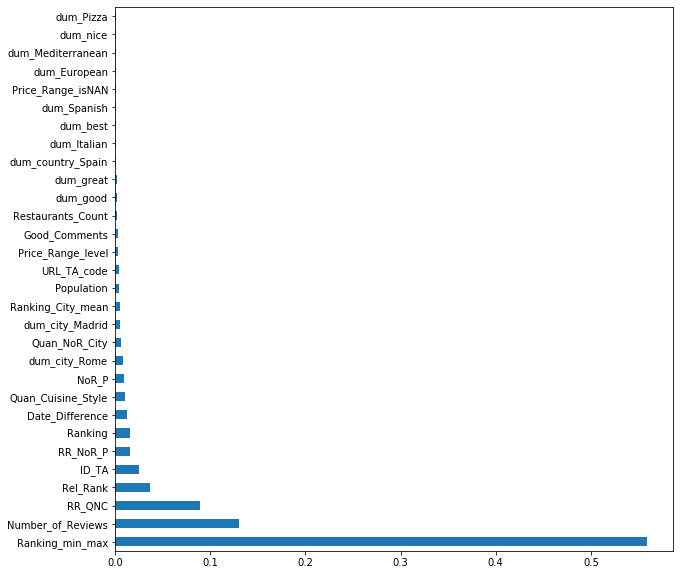

In [152]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [153]:
test_data.sample(10)

,Ranking,Number_of_Reviews,ID_TA,Rating,Number_of_Reviews_isNAN,Cuisine_Style_isNAN,Price_Range_isNAN,Restaurants_Count,Quan_Cuisine_Style,Ranking_min_max,...,dum_country_Norway,dum_country_Poland,dum_country_Portugal,dum_country_Slovenija,dum_country_Slovensko,dum_country_Spain,dum_country_Sweden,dum_country_Switzerland,dum_country_United Kingdom,dum_country_nan
2278,15682.0,15.0,2253979.0,0.0,0,0,0,7193,25,0.953658,...,0,0,0,0,0,0,0,0,1,0
8451,918.0,74.0,7140973.0,0.0,0,0,0,1314,40,0.304695,...,0,0,0,0,0,0,0,0,0,0
1662,1400.0,7.0,7056704.0,0.0,0,1,1,685,5,0.874296,...,0,0,0,0,0,0,0,1,0,0
2336,4278.0,0.0,11918250.0,0.0,1,0,0,3395,7,0.548453,...,0,0,0,0,0,1,0,0,0,0
5787,4428.0,33.0,6698149.0,0.0,0,1,1,6108,5,0.316456,...,0,0,0,0,0,0,0,0,0,0
8434,7274.0,284.0,5326228.0,0.0,0,0,0,7193,86,0.442316,...,0,0,0,0,0,0,0,0,1,0
3092,5688.0,35.0,2173106.0,0.0,0,0,0,7193,78,0.345861,...,0,0,0,0,0,0,0,0,1,0
900,312.0,425.0,1316063.0,0.0,0,0,0,745,66,0.176204,...,0,0,0,0,0,0,0,0,1,0
763,1065.0,0.0,7194365.0,0.0,1,0,1,925,35,0.494194,...,0,1,0,0,0,0,0,0,0,0
1992,1419.0,40.0,11814726.0,0.0,0,0,0,6108,26,0.101266,...,0,0,0,0,0,0,0,0,0,0


In [154]:
test_data = test_data.drop(['Rating'], axis=1)

In [155]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [156]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [157]:
predict_submission

array([3.06 , 4.225, 4.45 , ..., 3.07 , 4.485, 4.17 ])

In [158]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.060
1,id_1,4.225
2,id_2,4.450
3,id_3,4.390
4,id_4,4.420
5,id_5,4.440
6,id_6,1.570
7,id_7,3.205
8,id_8,4.105
9,id_9,4.505


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
